<a href="https://colab.research.google.com/github/likhithaap/Car-damage-assesment-deep-learning-/blob/main/damageassesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up Detectron2**

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html


     |████████████████████████████████| 274 kB 5.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=9b22540724a087b5697b24a00da3cc1a15d637408539c8c8ef10746849a5549b
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 928 kB/s 
     |████████████████████████████████| 130 kB 5.4 MB/s 
     |████████████████████████████████| 145 kB 27.6 MB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
     |████████████████████████████████| 843 kB 49.6 MB/s 
     |████████████████████████████████

In [1]:
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Loading and registering the dataset to Detectron2

In [2]:
! unzip archive.zip

Archive:  archive.zip
  inflating: img/1.jpg               
  inflating: img/10.jpg              
  inflating: img/13.jpg              
  inflating: img/14.jpg              
  inflating: img/15.jpg              
  inflating: img/16.jpg              
  inflating: img/17.jpg              
  inflating: img/18.jpg              
  inflating: img/19.jpg              
  inflating: img/2.jpg               
  inflating: img/20.jpg              
  inflating: img/21.jpg              
  inflating: img/22.jpg              
  inflating: img/23.jpg              
  inflating: img/24.jpg              
  inflating: img/25.jpg              
  inflating: img/26.jpg              
  inflating: img/27.jpg              
  inflating: img/29.jpg              
  inflating: img/3.jpg               
  inflating: img/30.jpg              
  inflating: img/31.jpg              
  inflating: img/32.jpg              
  inflating: img/33.jpg              
  inflating: img/34.jpg              
  inflating: img/36.jpg     

In [3]:
#setting variables for all paths in the dataset 
#dataset_dir = "../input/coco-car-damage-detection-dataset"
img_dir = "/content/img"
train_dir = "/content/train"
val_dir = "/content/val"

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/COCO_train_annos.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/val/COCO_val_annos.json", "/content/val")

In [5]:
dataset_dicts = DatasetCatalog.get("my_dataset_train")
metadata_dicts = MetadataCatalog.get("my_dataset_train")

[03/06 17:18:23 d2.data.datasets.coco]: Loaded 59 images in COCO format from /content/train/COCO_train_annos.json


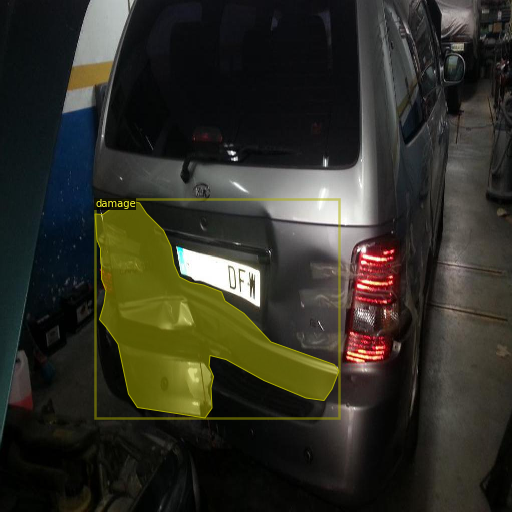

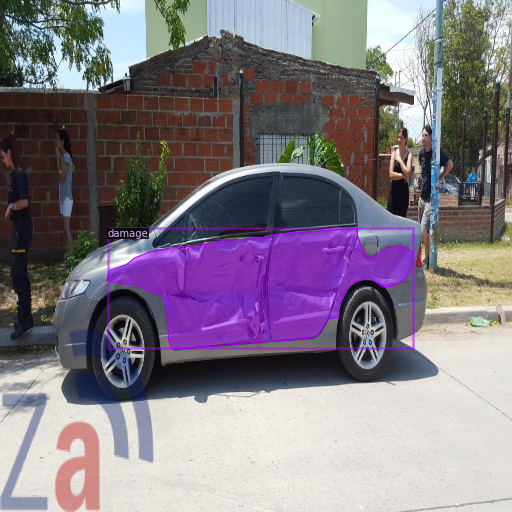

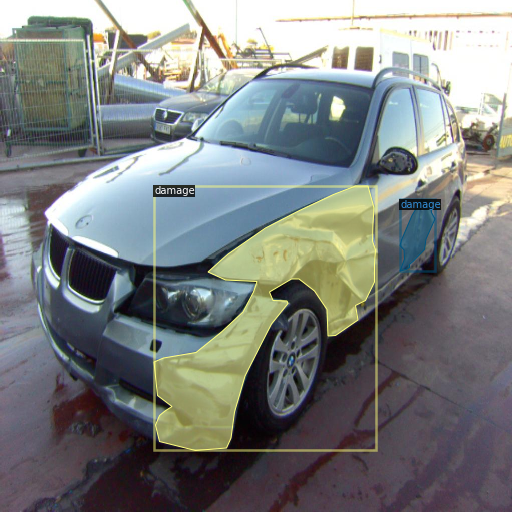

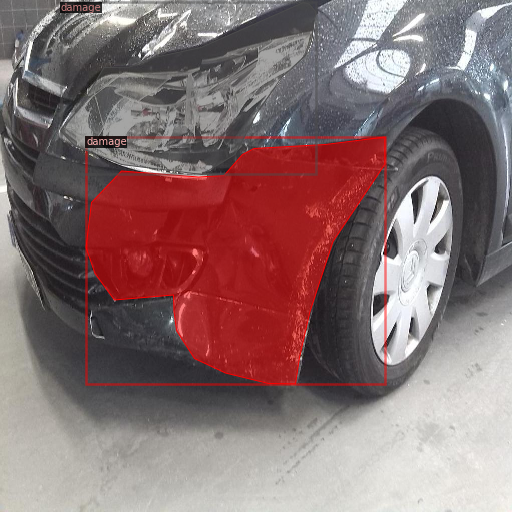

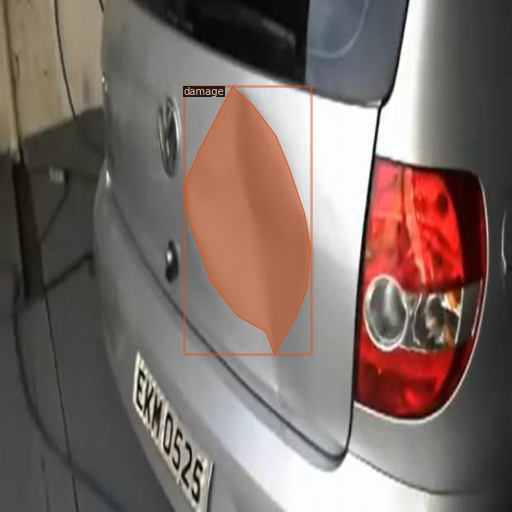

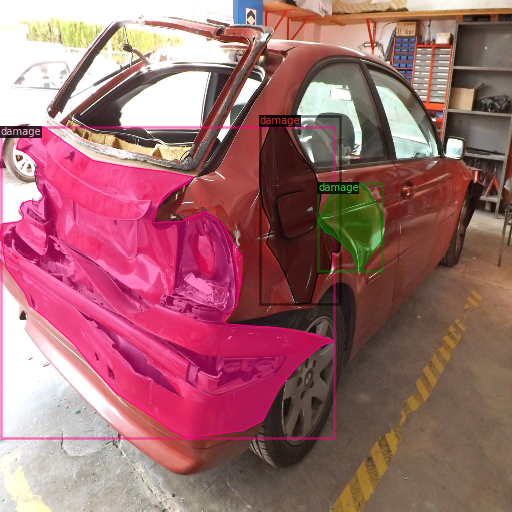

In [6]:
import random

for d in random.sample(dataset_dicts, 6):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_dicts, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])


In [7]:
from detectron2 import model_zoo
import os

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val")   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")# initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 300   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[03/06 17:18:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:03, 49.5MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pre

[03/06 17:18:59 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/06 17:19:17 d2.utils.events]:  eta: 0:04:10  iter: 19  total_loss: 1.547  loss_cls: 0.9361  loss_box_reg: 0.3395  loss_rpn_cls: 0.1621  loss_rpn_loc: 0.01851  time: 0.8768  data_time: 0.0198  lr: 6.427e-05  max_mem: 1832M
[03/06 17:19:35 d2.utils.events]:  eta: 0:03:53  iter: 39  total_loss: 1.115  loss_cls: 0.5249  loss_box_reg: 0.4721  loss_rpn_cls: 0.08991  loss_rpn_loc: 0.01752  time: 0.8686  data_time: 0.0091  lr: 0.00013087  max_mem: 1832M
[03/06 17:19:53 d2.utils.events]:  eta: 0:03:37  iter: 59  total_loss: 1.103  loss_cls: 0.467  loss_box_reg: 0.5124  loss_rpn_cls: 0.07437  loss_rpn_loc: 0.01722  time: 0.8805  data_time: 0.0114  lr: 0.00019747  max_mem: 1832M
[03/06 17:20:11 d2.utils.events]:  eta: 0:03:20  iter: 79  total_loss: 0.8657  loss_cls: 0.3511  loss_box_reg: 0.4352  loss_rpn_cls: 0.07164  loss_rpn_loc: 0.01354  time: 0.8896  data_time: 0.0105  lr: 0.00026407  max_mem: 1832M
[03/06 17:20:30 d2.utils.events]:  eta: 0:03:02  iter: 99  total_loss: 1.017  loss_cls: 0.

KeyError: ignored